# Day 6 Analysis

Geno Smith has been the story of the 2022 NFL Season. A 10 year back-up who has led the Seahawks to a winning record and doing it with the best completion percentage in the league through the first 7 weeks. How does his completion percentage compare to not only the other QBs playing this season but also to previous seasons' first 7 weeks?

## Set Up

In [236]:
import pandas as pd
from os import path
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Geno vs. The Field: 2022
First, let's look at how Geno's completion percentage ranks among other QBs this season.

In [237]:
query = """
SELECT
    player_id,
    player_display_name AS player_name,
    week,
    completions,
    attempts,
    ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
    passing_yards AS pass_yds,
    passing_tds AS pass_tds,
    interceptions AS int,
    passing_air_yards AS pass_air_yds,
    ROUND(fantasy_points,2) AS fantasy_pts,
    COUNT() OVER(PARTITION BY player_name) AS games_played
FROM weekly 
WHERE season = 2022
    AND week < 8
    AND position = 'QB'
    AND season_type = 'REG'
"""

df_2022 = pd.read_sql(query, conn)

In [238]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     248 non-null    object 
 1   player_name   248 non-null    object 
 2   week          248 non-null    int64  
 3   completions   248 non-null    int64  
 4   attempts      248 non-null    int64  
 5   comp_pct      240 non-null    float64
 6   pass_yds      248 non-null    float64
 7   pass_tds      248 non-null    int64  
 8   int           248 non-null    float64
 9   pass_air_yds  248 non-null    float64
 10  fantasy_pts   248 non-null    float64
 11  games_played  248 non-null    int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 23.4+ KB


In [239]:
df_2022[['attempts', 'completions', 'comp_pct']].describe()

,attempts,completions,comp_pct
count,248.000000,248.000000,240.000000
mean,29.729839,19.133065,63.172958
std,13.377257,9.075618,13.251246
min,0.000000,0.000000,0.000000
25%,22.750000,14.000000,58.000000
50%,32.000000,20.000000,63.810000
75%,38.000000,25.000000,70.092500
max,63.000000,42.000000,100.000000


Based on values for 25th and 75th percentiles, finding outliers using 1.5 * IQR will not be useful. Instead, I'll just take 50% of the mean as my lower value, or at least 15 passing attempts per game.

In [122]:
query = """
SELECT
    player_id,
    player_display_name AS player_name,
    week,
    completions,
    attempts,
    ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
    passing_yards AS pass_yds,
    passing_tds AS pass_tds,
    interceptions AS int,
    passing_air_yards AS pass_air_yds,
    ROUND(fantasy_points,2) AS fantasy_pts,
    COUNT() OVER(PARTITION BY player_name) AS games_played
FROM weekly 
WHERE season = 2022
    AND week < 8
    AND position = 'QB'
    AND season_type = 'REG'
    AND attempts >= 15
"""

df_2022_clean = pd.read_sql(query, conn)

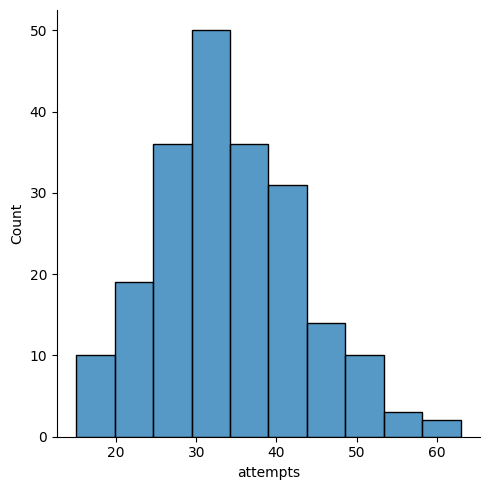

In [243]:
sns.displot(
    x="attempts",
    data=df_2022_clean,
    kind="hist",
    bins=10
)

In [124]:
df_2022_clean[['attempts', 'completions', 'comp_pct']].describe()

,attempts,completions,comp_pct
count,211.000000,211.000000,211.000000
mean,33.981043,21.905213,64.432322
std,9.185891,6.553844,8.836126
min,15.000000,7.000000,36.840000
25%,27.000000,18.000000,59.420000
50%,34.000000,21.000000,64.100000
75%,39.500000,26.000000,69.850000
max,63.000000,42.000000,90.910000


In [125]:
# Geno Smith's games
df_2022_clean[df_2022_clean['player_name'] == 'Geno Smith'][['week', 'completions', 'attempts', 'comp_pct']]

,week,completions,attempts,comp_pct
52,1,23,28,82.14
53,2,24,30,80.00
54,3,32,44,72.73
55,4,23,30,76.67
56,5,16,25,64.00
57,6,20,31,64.52
58,7,20,27,74.07


In [244]:
# Aggregate by week to find the average completion percentage per week
# Make sure to leave out Geno Smith to get the true average of his peers
by_week = df_2022_clean[df_2022_clean['player_name'] != 'Geno Smith'] \
    .groupby('week') \
    .mean() \
    .reset_index()

by_player_week = df_2022_clean \
    .groupby(['week', 'player_name']) \
    .mean() \
    .reset_index()

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_39813/2864774432.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean() \
/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_39813/2864774432.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean() \


In [158]:
by_week

,week,completions,attempts,comp_pct,pass_yds,pass_tds,int,pass_air_yds,fantasy_pts,games_played
0,1,22.354839,35.129032,63.452258,245.225806,1.580645,0.870968,259.161290,16.692903,5.516129
1,2,22.400000,34.833333,64.327667,242.833333,1.800000,0.833333,264.400000,17.910000,5.766667
2,3,22.516129,35.645161,63.221935,251.870968,1.193548,0.677419,290.032258,15.597419,5.774194
3,4,20.310345,31.931034,62.921724,230.310345,1.379310,0.793103,243.413793,15.381379,5.896552
4,5,21.709677,33.741935,64.595161,239.096774,0.935484,0.645161,254.677419,14.625161,5.774194
5,6,21.307692,33.538462,63.316154,218.961538,1.307692,0.615385,233.038462,14.712308,5.692308
6,7,22.500000,33.538462,67.344615,246.076923,1.192308,0.730769,245.769231,15.300769,5.269231


In [245]:
by_player_week[by_player_week['player_name'] == 'Geno Smith']

,week,player_name,completions,attempts,comp_pct,pass_yds,pass_tds,int,pass_air_yds,fantasy_pts,games_played
7,1,Geno Smith,23.0,28.0,82.14,195.0,2.0,0.0,144.0,17.20,7.0
39,2,Geno Smith,24.0,30.0,80.00,197.0,0.0,1.0,162.0,6.08,7.0
70,3,Geno Smith,32.0,44.0,72.73,325.0,2.0,1.0,412.0,18.90,7.0
103,4,Geno Smith,23.0,30.0,76.67,320.0,2.0,0.0,320.0,31.70,7.0
134,5,Geno Smith,16.0,25.0,64.00,268.0,3.0,0.0,294.0,24.02,7.0
163,6,Geno Smith,20.0,31.0,64.52,197.0,0.0,0.0,213.0,12.68,7.0
192,7,Geno Smith,20.0,27.0,74.07,210.0,2.0,1.0,206.0,13.10,7.0


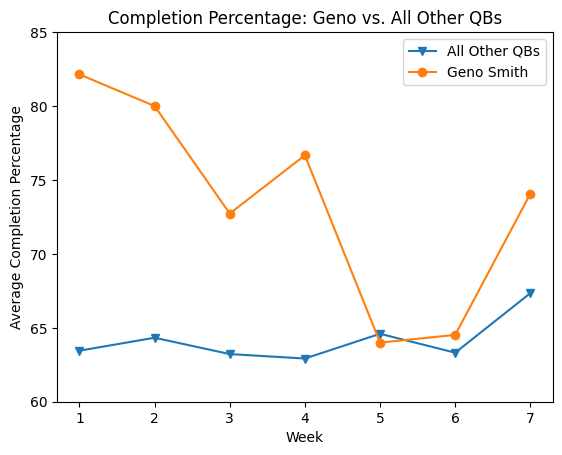

In [247]:
plt.plot(
    'week', 
    'comp_pct', 
    data=by_week,
    marker='v', 
    label='All Other QBs',)
plt.plot(
    'week', 
    'comp_pct', 
    data=by_player_week[by_player_week['player_name'] == 'Geno Smith'],
    marker='o',
    label='Geno Smith')

plt.xlabel('Week')
plt.ylabel('Average Completion Percentage')
plt.title('Completion Percentage: Geno vs. All Other QBs')

plt.legend(loc="upper right")
plt.ylim(60,85)

plt.show()

Geno started out hot, reverted to the mean weeks 5-6 and rebounded Week 7. Overall, he is having quite a season, doing quite a bit better than the league average. in terms of completion percentage.

In [248]:
# Get the top 5 QBs by average completion percentage
df_2022_clean.groupby('player_name')[['comp_pct','games_played']] \
    .mean() \
    .sort_values('comp_pct', ascending=False)[:5]

,comp_pct,games_played
player_name,,
Geno Smith,73.447143,7.0
Matthew Stafford,71.643333,6.0
Bailey Zappe,70.462500,4.0
Joe Burrow,68.934286,7.0
Daniel Jones,68.531667,6.0


Geno does indeed have the highest average completion percentage among NFL QBs this season. Controlling for games played, he's beating Joe Burrow by ~4.5%, who has also started every game.

## Geno vs. The Field: 1999-2022
Below is a recreation of the above analysis using data from [nflverse](https://nflverse.nflverse.com) going back to 1999. Is Geno Smith having a historic season?

In [249]:
# Get data for all seasons

query = """
SELECT
    player_id,
    player_display_name AS player_name,
    season,
    week,
    completions,
    attempts,
    ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
    passing_yards AS pass_yds,
    passing_tds AS pass_tds,
    interceptions AS int,
    passing_air_yards AS pass_air_yds,
    ROUND(fantasy_points,2) AS fantasy_pts,
    COUNT() OVER(PARTITION BY player_name, season) AS games_played
FROM weekly 
WHERE week < 8
    AND position = 'QB'
    AND season_type = 'REG'
    AND attempts >= 15
"""

df_all = pd.read_sql(query, conn)

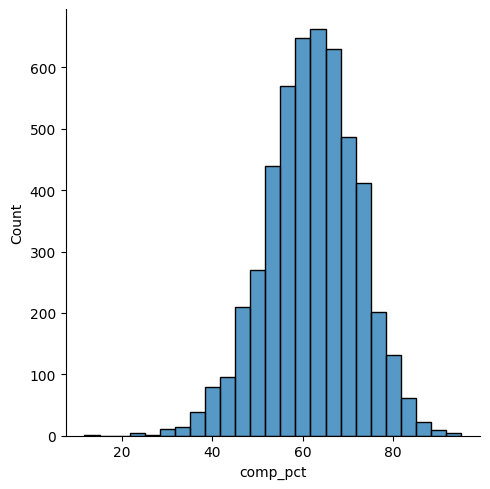

In [250]:
# Check distribution

sns.displot(
    x="comp_pct",
    data=df_all,
    kind="hist",
    bins=25
)

In [167]:
df_all[['comp_pct','attempts','completions']].describe()

,comp_pct,attempts,completions
count,5002.000000,5002.000000,5002.000000
mean,62.028910,32.958816,20.472811
std,10.025591,8.746097,6.306077
min,11.760000,15.000000,2.000000
25%,55.560000,27.000000,16.000000
50%,62.260000,33.000000,20.000000
75%,68.750000,39.000000,24.000000
max,95.000000,68.000000,45.000000


In [252]:
# Filter out Geno's data for this season
geno_2022 = (df_all['player_name'] == 'Geno Smith') & (df_all['season'] == 2022)

by_week_all = df_all[~geno_2022].groupby('week').mean().reset_index()

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_39813/3040588277.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_week_all = df_all[~geno_2022].groupby('week').mean().reset_index()


In [253]:
by_week_all

,week,season,completions,attempts,comp_pct,pass_yds,pass_tds,int,pass_air_yds,fantasy_pts,games_played
0,1,2010.608753,20.716180,33.221485,62.360809,234.737401,1.432361,0.874005,193.974801,14.660451,73.938992
1,2,2010.498695,20.502611,32.950392,62.039948,235.569191,1.417755,0.887728,199.633159,14.917154,74.003916
2,3,2010.858311,20.828338,33.254768,62.713665,238.121253,1.400545,0.874659,206.929155,15.002643,69.209809
3,4,2010.747518,20.601418,33.092199,62.080043,236.953191,1.439716,0.870922,198.165957,14.878411,71.380142
4,5,2010.679767,20.497817,33.062591,61.865138,235.512373,1.420670,0.917031,194.508006,14.811325,72.921397
5,6,2010.572917,20.363095,33.093750,61.547917,235.291667,1.386905,0.970238,200.007440,14.584435,72.340774
6,7,2010.406204,19.710487,32.000000,61.376691,225.087149,1.361891,0.861152,189.886263,14.164786,74.521418


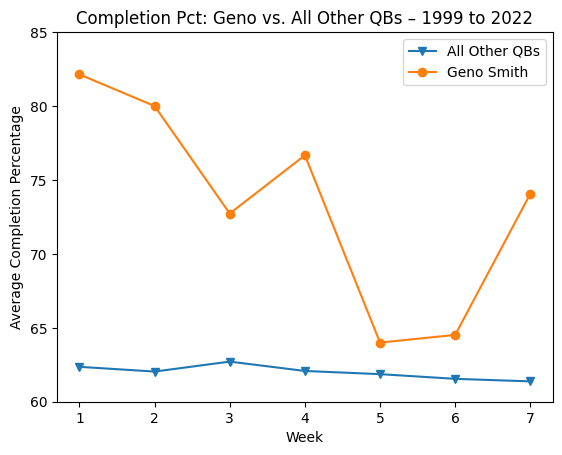

In [257]:
plt.plot(
    'week', 
    'comp_pct', 
    data=by_week_all,
    marker='v', 
    label='All Other QBs',)
plt.plot(
    'week', 
    'comp_pct', 
    data=by_player_week[by_player_week['player_name'] == 'Geno Smith'],
    marker='o',
    label='Geno Smith')

plt.xlabel('Week')
plt.ylabel('Average Completion Percentage')
plt.title('Completion Pct: Geno vs. All Other QBs – 1999 to 2022')

plt.legend(loc="upper right")
plt.ylim(60,85)

plt.show()

### Ranking Geno's 2022 Season

In [205]:
# Get data for all seasons

query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week < 8
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 15
)
SELECT
    player_name,
    season,
    week,
    attempts,
    completions,
    comp_pct,
    COUNT() OVER(PARTITION BY player_name, season) AS games_played,
    fantasy_pts,
    RANK() OVER(PARTITION BY week ORDER BY comp_pct DESC) AS r_comp_pct_by_week
FROM data
"""

df_best = pd.read_sql(query, conn)

In [207]:
best_per_week = df_best[df_best['r_comp_pct_by_week'] == 1]
best_per_week

,player_name,season,week,attempts,completions,comp_pct,games_played,fantasy_pts,r_comp_pct_by_week
1770,Drew Brees,2018,5,29,26,89.66,6,26.72,1
1929,Gardner Minshew,2020,1,20,19,95.00,7,20.82,1
3019,Kurt Warner,2009,2,26,24,92.31,6,17.62,1
4252,Ryan Fitzpatrick,2020,3,20,18,90.00,6,24.20,1
4285,Ryan Tannehill,2015,7,19,18,94.74,6,27.58,1
4462,Steve McNair,2003,4,16,15,93.75,7,18.94,1
4890,Trevor Lawrence,2022,6,22,20,90.91,7,24.90,1


In [210]:
df_best[(df_best['player_name'] == 'Geno Smith') & (df_best['season'] == 2022)]

,player_name,season,week,attempts,completions,comp_pct,games_played,fantasy_pts,r_comp_pct_by_week
1952,Geno Smith,2022,1,28,23,82.14,7,17.20,13
1953,Geno Smith,2022,2,30,24,80.00,7,6.08,25
1954,Geno Smith,2022,3,44,32,72.73,7,18.90,103
1955,Geno Smith,2022,4,30,23,76.67,7,31.70,51
1956,Geno Smith,2022,5,25,16,64.00,7,24.02,291
1957,Geno Smith,2022,6,31,20,64.52,7,12.68,256
1958,Geno Smith,2022,7,27,20,74.07,7,13.10,76


For all the talk, none of Geno's weekly performances in the 2022 even crack the top 10 in terms of completion percentages. However, if we compare the number of attempts by Geno Smith vs. the top performers, we see a big discrepancy – the best performers only threw 20-25 times! Geno throws around 25-30 times. 

Increasing the attempts threshold from 15 to 25 and re-running the rankings will make for a better comparison.

In [211]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week < 8
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 25
)
SELECT
    player_name,
    season,
    week,
    attempts,
    completions,
    comp_pct,
    COUNT() OVER(PARTITION BY player_name, season) AS games_played,
    fantasy_pts,
    RANK() OVER(PARTITION BY week ORDER BY comp_pct DESC) AS r_comp_pct_by_week
FROM data
"""

df_best_GTE_25_att = pd.read_sql(query, conn)

df_best_GTE_25_att[(df_best_GTE_25_att['player_name'] == 'Geno Smith') & (df_best_GTE_25_att['season'] == 2022)]

,player_name,season,week,attempts,completions,comp_pct,games_played,fantasy_pts,r_comp_pct_by_week
1632,Geno Smith,2022,1,28,23,82.14,7,17.20,10
1633,Geno Smith,2022,2,30,24,80.00,7,6.08,23
1634,Geno Smith,2022,3,44,32,72.73,7,18.90,82
1635,Geno Smith,2022,4,30,23,76.67,7,31.70,39
1636,Geno Smith,2022,5,25,16,64.00,7,24.02,241
1637,Geno Smith,2022,6,31,20,64.52,7,12.68,212
1638,Geno Smith,2022,7,27,20,74.07,7,13.10,60


A little better but not remarkable. His Week 1 performance was top 10 but that's really the only thing that was remarkable. To add insult to injury that performance only netted a middling 17.20 fantasy points.

Last chance, let's rank his average through the first 7 weeks vs. every QB's average through the first 7 weeks. Will keep the attempts threshold at 25 per game.

In [260]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week < 8
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 25
), aggregations AS (
    SELECT
       player_name,
       season,
       ROUND(AVG(comp_pct), 2) AS avg_comp_pct,
       ROUND(AVG(attempts), 2) AS avg_attempts,
       COUNT(*) AS num_games
    FROM data
    GROUP BY player_name, season
), rankings AS (
    SELECT
        player_name,
        season,
        avg_comp_pct,
        avg_attempts,
        num_games,
        ROW_NUMBER() OVER(ORDER BY avg_comp_pct DESC) AS r_avg_comp_pct
    FROM aggregations
)
SELECT *
FROM rankings
WHERE num_games = 7
"""

pd.read_sql(query, conn).head(10)

,player_name,season,avg_comp_pct,avg_attempts,num_games,r_avg_comp_pct
0,Tom Brady,2007,75.13,32.71,7,11
1,Geno Smith,2022,73.45,30.71,7,19
2,Kyler Murray,2021,73.23,31.86,7,23
3,Peyton Manning,2013,72.47,41.29,7,27
4,Teddy Bridgewater,2020,72.06,33.43,7,34
5,Matt Ryan,2018,71.88,37.57,7,39
6,Drew Brees,2011,71.51,42.71,7,43
7,Dak Prescott,2019,71.43,34.00,7,44
8,Aaron Rodgers,2011,71.32,34.14,7,46
9,Matt Ryan,2019,71.15,40.71,7,48


When controlling for players who have played every game through Week 7, Geno is actually having a historically good start to the season! The top 10 list includes some of the best to ever play QB such as Tom Brady, Peyton Manning, Drew Brees, and Aaron Rodgers.

It will be interesting to revisit this towards the end of the season to see if Geno can keep it up!